# Intro to PyTorch

## Prerequisites
- [Bias, variance and generalisation](https://github.com/AI-Core/Strong-ML-Foundations/blob/master/Bias%2C%20variance%20and%20generalisation.ipynb)

## What is PyTorch?

Remember when we implemented our first linear model that we trained with gradient descent? When we did that we had to write out functions which computed the gradient of the error/loss with respect to every different parameter in our model. These functions differed depending on how that parameter mathematically contributed to the loss (e.g. was it added to something, or multiplied by something that eventually affected the value of the loss).

PyTorch is a numerical computation library like Numpy, made and maintained by Facebook. It has a core feature called **automatic differentiation**, which will help us to not have to write out these functions for each parameter. This is critical for deep learning as our neural networks can easily have millions of parameters.

At the heart of PyTorch are a new data type, **torch tensors**.

In [1]:
# this cell just imports the libraries that we will use later
import numpy as np   # for tensor math
import torch    # our deep learning framework
import torch.nn.functional as F    # contains functions like mean squared error that dont have parameters and can be called functionally
from random import shuffle

In [2]:
X = torch.rand(1)   # create a random torch tensor (a single number (scalar) to start with)
print(type(X)) # print it's type
W = torch.rand(1)   # create another random tensor
B = torch.rand(1)   # create again another random tensor
Y = W*X + B    # compute a tensor from the ones which we already created
print(type(Y)) # the type of a variable computed from a torch tensor will also be a torch tensor

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [4]:
X = torch.rand(3, 2, 4) # create a random tensor of size (3, 2, 4)
print(X)
print(X.shape)

tensor([[[0.9067, 0.6638, 0.1370, 0.0675],
         [0.3325, 0.9672, 0.8261, 0.5824]],

        [[0.7618, 0.7363, 0.8903, 0.7693],
         [0.6755, 0.5882, 0.2024, 0.1866]],

        [[0.2834, 0.0171, 0.2808, 0.2591],
         [0.5832, 0.2778, 0.1579, 0.8904]]])
torch.Size([3, 2, 4])


So far, we've just used PyTorch like we would use numpy. Eventually we want to be able to use PyTorch to optimise the parameters of models which represent the learnt relationships between our input features and output labels. To do this using gradient based optimisation methods (like gradient descent) we need to be able to compute how the error which we compute changes as we change our model's parameters (we need the gradient of our error with respect to each of our model parameters). 

### `.grad_fn` - Keeping track of how tensors were computed
Torch tensors track which operation (if any) was applied to which inputs to create them. They store this information in an attribute called `.grad_fn`. By chaining together these relationships PyTorch builds a **computational graph** which displays how all variables relate to each other. The `.grad_fn` is the function that was performed on the incoming values to compute the value at a particular node.

Below is a diagram of a computational graph that represents a simple linear regression model.

![](./images/comp_graph.jpg)

### `.requires_grad` - What tensors do I want to keep track of?
The point of the computational graph is to show how the variables, that we require gradients of our loss with respect to, contribute to that loss. Using the `.grad_fn` we can work our way back from the loss to each of these variables. However, PyTorch `.grad_fn` attributes will only be created for variables that are computed from tensors that have a `.requires_grad` attribute equal to `True`. This `.requires_grad` attribute tells PyTorch that we want to be able to work our way back from our final output to here because we require the gradient of that final output with respect to this variable. As such, this variable is included in the computational graph, and all variables that are subsequently created from it will necessarily have a `.grad_fn` and `.requires_grad=True` and be included in the graph.

In [5]:
X = torch.rand(1)   # create a random scalar
W = torch.rand(1, requires_grad=True)    # create a tensor that we want to compute gradients with respect to (requires grad) 
B = torch.rand(1, requires_grad=True)
Y = W*X + B

print('X:', X)
print()
print('W:', W) # note the requires_grad attribute shown
print('W grad_fn:', W.grad_fn)    # W was created randomly so it has no grad_fn to specify what operation created it
print()
print('B:', B)
print()
print('Y;', Y)
print('Y.requires_grad:', Y.requires_grad)
print('Y.grad_fn:', Y.grad_fn)

X: tensor([0.9457])

W: tensor([0.9043], requires_grad=True)
W grad_fn: None

B: tensor([0.1572], requires_grad=True)

Y; tensor([1.0125], grad_fn=<AddBackward0>)
Y.requires_grad: True
Y.grad_fn: <AddBackward0 object at 0x000001CAD3289608>


## Differentiation in PyTorch and more about `torch.tensors`

**The chain rule** shows us that we can compute a derivative of a function by chaining together the derivatives of the functions that connect those variables.

![](./images/grad.jpg)

By looking at our computational graph, we can see which functions connect any variables by following the arcs backward from the furthest point forward. PyTorch has many useful functions that can be used as layers in our models. Because PyTorch expects us to be differentiating (it is an automatic differentiation library), it also has associated gradient computing functions for each of the layers it provides. So by evaluating these gradient functions of the functions that relate two variables that we care about and multiplying them together, we can compute the derivative of one with respect to another. 

### Computing the gradient automatically - `.backward()`
Differentiation in PyTorch is easy. We simply call the `.backward()` method on any tensor that we want to differentiate. When we call `.backward()` on a tensor, PyTorch will compute how its value changes as we consider changing every tensor that contributes to it (which has `.requires_grad=True`) in turn. It does this by recursively looking at the `.grad_fn` of that tensor, working it's way backward through the computational graph. 

### Where does a tensor's gradient get stored? `.grad`
The values of the gradients for each of the contributing tensors get **added** to (they don't replace) each of their respective `.grad` attributes. This happens without us having to write the gradient functions, or perform their multiplication to apply the chain rule. 

So not only do torch tensors store their current values, but they can also store gradients (how their change affects other tensors).

In [6]:
Y.backward()    # differentiate our Y
print('X.grad:', X.grad)
print('W.grad:', W.grad)
print('B.grad:', B.grad)
print('Y.grad:', Y.grad)

X.grad: None
W.grad: tensor([0.9457])
B.grad: tensor([1.])
Y.grad: None


## Linear regression in PyTorch

Now let's try to use what we've learn about PyTorch and tensors to solve a real problem.

We'll start by making some fake data where the output is a linear function of the input.

X: [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ] 

Y: [0.7        0.80526316 0.91052632 1.01578947 1.12105263 1.22631579
 1.33157895 1.43684211 1.54210526 1.64736842 1.75263158 1.85789474
 1.96315789 2.06842105 2.17368421 2.27894737 2.38421053 2.48947368
 2.59473684 2.7       ] 

(20,)
(20,)


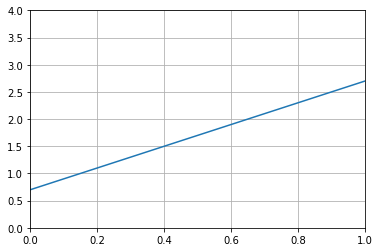

In [11]:
# this is just a helper function to generate some sample data for us
def sample_linear_data(m=20):
    X = np.linspace(0, 1, m)    # create an array of m numbers linearly spaced (linspace) between 0 and 1
    Y = 2*X + 0.7    # simple equation for a linear (straight line) relationship between X and Y
    return X, Y #returns X (the input) which should have shape (m, 2) and Y (labels) which should have shape (m, 1)

X, Y = sample_linear_data()    # create some sample data
print('X:',X, '\n')
print('Y:',Y, '\n')
print(X.shape)
print(Y.shape)
import matplotlib.pyplot as plt
plt.grid()
plt.ylim(0, 4)
plt.xlim(0, 1)
plt.plot(X, Y)    # plot Y against X
plt.show()        # show the plot


## Now let's build a model that will learn to represent this input-output relationship

PyTorch makes it really easy for us to build complex models that can be improved via gradient based optimisation. It does this by providing a class named `torch.nn.Module`. Our model classes should inherit from this class because it does a few very useful things for us:

1. `torch.nn.Module` keeps track of all `torch.nn.Parameters` that are created within it. So when we add a linear layer to our model, the parameters (matrix of weights) in that layer will be added to a list of our model's parameters. We can retrieve all parameters of our model using its `parameters()` method. We will later pass this (`mymodel.parameters()`) to our optimiser when we tell it that *this* is what it should be optimising.


2. `torch.nn.Module` treats the `forward` method (function) of any child class specially by assigning it to the `__call__` method. That means that running `mymodel.forward(some_data)` is equal to `mymodel(some_data)`. 

In [8]:
class LinearModel(torch.nn.Module): # create a model class that inherits from torch.nn.Module
    def __init__(self): # define the constructor
        super().__init__() # initialise the parent class (torch.nn.Module)
        self.linear_layer = torch.nn.Linear(1, 1) # initialise a linear layer (this initialises its parameters)
        
    def forward(self, x): # define what happens to data that passes forward through the model
        x = self.linear_layer(x) # pass our data through our linear layer
        return x # return the output

## What data can a PyTorch model process?

### What type should it be?
Most models will have parameters that control what transformations are applied to the data they process. The parameters which are initialised in each layer of a PyTorch model are of type `torch.tensor`. Many of these transformations, like matrix multiplication between two tensors, won't work between data of different types.

We have created our fake data as type `numpy.ndarray`. So let's convert it into a torch tensor.

In [12]:
print(type(X))    # print type before
X = torch.tensor(X) # make X into torch tensor
print(type(X))    # print type after
Y = torch.tensor(Y)# make Y into torch tensor

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


### What size does a layer expect its inputs to be?

PyTorch models expect to be fed data of shape `(batch_size, example_shape)`. That is, it expects a of examples, and each example should also be a list. All of that is still required to be of type `torch tensor`. See more [here](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)

In [13]:
# reshape
print(X.shape)
X = X.view(-1, 1)    # reshape X to have 1 column, and however many rows it needs
Y = Y.view(-1, 1)    # reshape Y similarly
print(X.shape)

torch.Size([20])
torch.Size([20, 1])


### Specifically what type of tensor?

On a computer, numbers can be stored with varying levels of precision. By default, the model parameters are stored as 32 bit floating point numbers (called type `Float`). But our fake datapoints that were transformed into a torch tensor are all 64 but floating point (called type `Double`). So we need to convert either the model parameters or the data into the other type so that they match and we can perform computations between them. 

64 bit floats are twice as accurate as, but take up twice the memory of 32 bit floats.

In [14]:
model = LinearModel() # create instance of model
model = model.double() # convert model parameters' datatype to match that of our inputs
pred = model(X)    # make a prediction of an output corresponding to an input that we pass through our model
print(pred)

tensor([[0.3428],
        [0.3770],
        [0.4113],
        [0.4456],
        [0.4798],
        [0.5141],
        [0.5483],
        [0.5826],
        [0.6168],
        [0.6511],
        [0.6854],
        [0.7196],
        [0.7539],
        [0.7881],
        [0.8224],
        [0.8567],
        [0.8909],
        [0.9252],
        [0.9594],
        [0.9937]], dtype=torch.float64, grad_fn=<AddmmBackward>)


## Optimisation in PyTorch

As well as providing tensors and layers, PyTorch provides optimisers. This means that we don't have to write our own optimisers which again are likely to be slower and less efficient. We also don't have to stay up to date with  the latest state of the art optimisers. We don't even need to know how they work to be honest. We can just let Facebook do the hard work for us!

A module named `torch.optim` contains many classes that are templates for common optimisers. They include SGD, Adam, RMSProp, Ada and many more optimisers. Most of the time we should just use SGD or Adam.

### `.parameters()`
When we initialise our PyTorch optimisers, we need to tell it what it will be optimising. What should it be optimising? When we create our model that inherits from `torch.nn.Module`, PyTorch looks out for any attributes within it that also inherit from `torch.nn.Module` (like our `Linear` layer). It knows that the weights of these layers are parameters of our model, and they are automatically added to the model's list of parameters (see more [here](https://pytorch.org/docs/stable/nn.html#torch.nn.Parameter)). We can get the parameters of our model at any point by using it's `.parameters()` method (thanks to the fact that the model inherited from `torch.nn.Module`).

Most optimisers also require an initial learning rate, so we should pass that in too.

### `.step()`
The optimisers that PyTorch provides all use the gradient of the loss (with respect to the parameters that they optimise) to compute how much they should update each weight and in what direction. They access this gradient by looking at the `.grad` attribute for all the parameters that they optimise, which is computed when we call `.backward` on any variable that these parameters affect. We can use the optimiser's `.step()` method  to actually perform the parameter updates - this is the ***learning*** in machine learning.

### `.zero_grad()`
Calling `.backward()` **does not reset** the existing parameter values of `.grad` for the tensore which gradients are computed for. Instead it **accumulates** them, adding to what was previously there. We may not want this, and we can use out optimiser's `.zero_grad()` method to reset the `.grad` values of the parameters which it's optimising back to zero.

## Let's combine all of that to train a simple linear model in PyTorch

Epoch: 0 	Loss: 0.45885795271861846
Epoch: 1 	Loss: 0.24004805583339492
Epoch: 2 	Loss: 0.1601608211083201
Epoch: 3 	Loss: 0.13525421493061668
Epoch: 4 	Loss: 0.12151233679837062
Epoch: 5 	Loss: 0.1086640194528556
Epoch: 6 	Loss: 0.09618901061842347
Epoch: 7 	Loss: 0.0843687143196092
Epoch: 8 	Loss: 0.07335677927733573
Epoch: 9 	Loss: 0.0632486668819774
Epoch: 10 	Loss: 0.0540929221166764
Epoch: 11 	Loss: 0.045899283753358174
Epoch: 12 	Loss: 0.03864786747908807
Epoch: 13 	Loss: 0.03229690189303392
Epoch: 14 	Loss: 0.026789258867569304
Epoch: 15 	Loss: 0.022057881665734726
Epoch: 16 	Loss: 0.018030217209578026
Epoch: 17 	Loss: 0.014631759724648313
Epoch: 18 	Loss: 0.011788806653735776
Epoch: 19 	Loss: 0.009430524466396565
Epoch: 20 	Loss: 0.007490419405029114
Epoch: 21 	Loss: 0.005907304893510712
Epoch: 22 	Loss: 0.004625852777213228
Epoch: 23 	Loss: 0.0035968097052662606
Epoch: 24 	Loss: 0.0027769529235174514
learnt weight: tensor([[1.8292]], dtype=torch.float64) 	learnt bias: tensor(

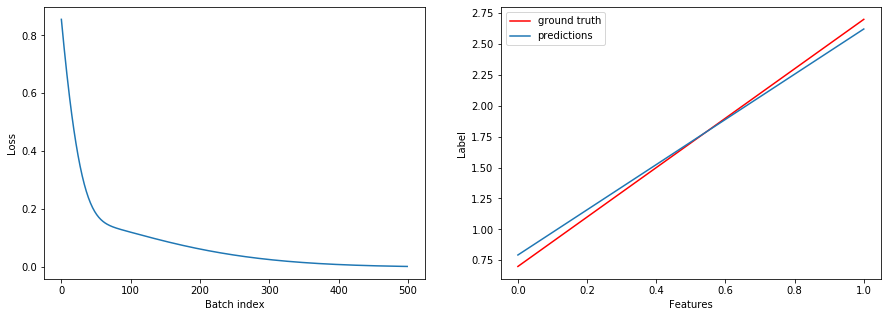

In [19]:
H = LinearModel() # instantiate our model
H = H.double() # convert model parameter type to same as our data (double)
optimiser = torch.optim.Adam(H.parameters(), lr=0.01)    # use PyTorch's Stochastic Gradient Descent optimiser
L =  F.mse_loss   # use a pytorch function that computes the mean squared error (mse)

epochs = 25
losses = []
for epoch in range(epochs):
    for x, y in zip(X, Y):    # iterate through batches
        prediction = H(X) # make a prediction using our model
        loss = L(prediction, Y) # compute the loss
        loss.backward() # differentiate the loss with respect to all variables that contribute to it in the computational graph and have requires_grad=True
        optimiser.step() # take an optimisation step (update weights)
        optimiser.zero_grad() # reset gradients to zero (otherwise they accumulate)
        losses.append(loss) # add loss from this batch to our total list of losses (for plotting later)
    print(f'Epoch: {epoch} \tLoss: {loss}')
        
# GET THE LEARNT PARAMETERS
w = H.linear_layer.weight.detach()    # detach removes the tensor from the graph so we can do numpy computation on it
b = H.linear_layer.bias.detach()
print('learnt weight:', w, '\tlearnt bias:', b)
    
# PLOT THE LOSS CURVE AND OUR HYPOTHESIS
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Batch index')
ax1.plot(losses)

ax2 = fig.add_subplot(122)
ax2.set_ylabel('Label')
ax2.set_xlabel('Features')
ax2.plot(X, Y, c='r', label='ground truth')
ax2.plot(X, w*X+b, label='predictions')
ax2.legend()
plt.show()

## You've finished this notebook!

Next steps:
- [Classification](https://github.com/AI-Core/Strong-ML-Foundations/blob/master/Classification.ipynb)

## Further reading
- [Article on PyTorch](https://towardsdatascience.com/getting-started-with-pytorch-part-1-understanding-how-automatic-differentiation-works-5008282073ec)